**DATA ANALYSIS AND PREDICTION OF BIKE SHARING DEMAND DATASET**

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

In [2]:
#Loading the dataset
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
print("Nulls in training dataset:",train.isnull().sum().sum())
print("Nulls in testing dataset:",test.isnull().sum().sum())

Nulls in training dataset: 0
Nulls in testing dataset: 0


In [6]:
print("Shape of the training dataset: ",train.shape)
print("Shape of the testing dataset : ",test.shape)

Shape of the training dataset:  (10886, 12)
Shape of the testing dataset :  (6493, 9)


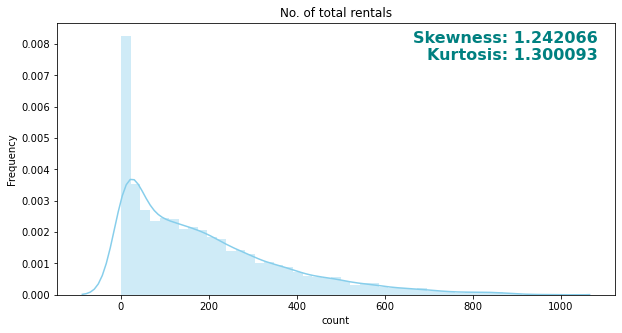

In [7]:
#Sale Price distribution
plt.figure(figsize=(10,5))
ax=sns.distplot(train["count"], hist=True , color='skyblue')
ax.text(x=0.97, y=0.97,transform=ax.transAxes, s="Skewness: %f" % train["count"].skew(),\
        fontweight='demibold', fontsize=16, verticalalignment='top', horizontalalignment='right',\
         color='teal')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % train["count"].kurt(),\
        fontweight='demibold', fontsize=16, verticalalignment='top', horizontalalignment='right',\
       color='teal')
plt.ylabel('Frequency')
plt.title('No. of total rentals')
plt.show()

The count distribution is highly skewed and platykurtic.We do the transformation by log1p.

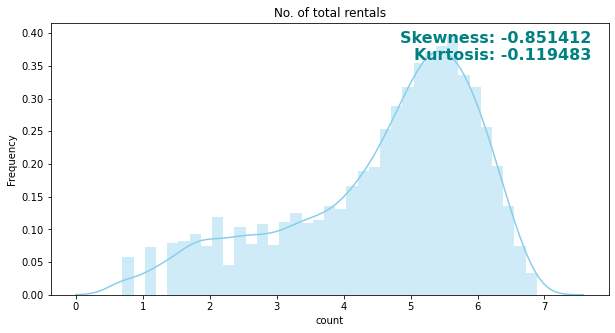

In [8]:
#Sale Price distribution
plt.figure(figsize=(10,5))
ax=sns.distplot(np.log1p(train["count"]), hist=True , color='skyblue')
ax.text(x=0.97, y=0.97,transform=ax.transAxes, s="Skewness: %f" % np.log1p(train["count"]).skew(),\
        fontweight='demibold', fontsize=16, verticalalignment='top', horizontalalignment='right',\
         color='teal')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % np.log1p(train["count"]).kurt(),\
        fontweight='demibold', fontsize=16, verticalalignment='top', horizontalalignment='right',\
       color='teal')
plt.ylabel('Frequency')
plt.title('No. of total rentals')
plt.show()

In [9]:
#removing the outliars
Q1 =np.log1p(train['count']).quantile(0.25)
Q3 =np.log1p(train['count']).quantile(0.75)
IQR = Q3 - Q1
filter=(np.log1p(train['count']) >= Q1 - 1.5 * IQR) & (np.log1p(train['count'])<= Q3 + 1.5 *IQR)
train=train.loc[filter]
train.shape

(10781, 12)

In [10]:
#adding the additional columns required
train['hour'] = pd.DatetimeIndex(train['datetime']).hour
train['day'] = pd.DatetimeIndex(train['datetime']).day
train['month'] = pd.DatetimeIndex(train['datetime']).month
train['year'] = pd.DatetimeIndex(train['datetime']).year
train["weekday"]=pd.DatetimeIndex(train['datetime']).weekday
test["weekday"]=pd.DatetimeIndex(test['datetime']).weekday
test['hour'] = pd.DatetimeIndex(test['datetime']).hour
test['day'] = pd.DatetimeIndex(test['datetime']).day
test['month'] = pd.DatetimeIndex(test['datetime']).month
test['year'] = pd.DatetimeIndex(test['datetime']).year
d=test["datetime"]
test["weekend"]=0
test.loc[(train["holiday"]==0) & (test["workingday"]==0),"weekend"]=1
train["weekend"]=0
train.loc[(train["holiday"]==0) & (train["workingday"]==0),"weekend"]=1

In [11]:
#correlation of columns with the count column
corr=train[train.columns[1:]].corr()['count'][:]
corr

season        0.156051
holiday      -0.006611
workingday    0.014345
weather      -0.128764
temp          0.387888
atemp         0.383170
humidity     -0.318426
windspeed     0.104040
casual        0.688492
registered    0.970644
count         1.000000
hour          0.393450
day           0.017841
month         0.159620
year          0.258620
weekday      -0.003902
weekend      -0.012297
Name: count, dtype: float64


Columns such as casual , registered and temp have good correlation with the counts column. We also see that temperature and feels like temperature has similar correlation and as they mean the same thing so we can drop either of the one column.

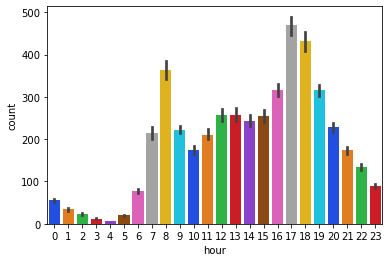

In [12]:
#number of rentals according to day time
sns.barplot(y='count', x="hour", data=train, palette="bright")

The bike demands are high at around 8 a.m. and 5-6 p.m.

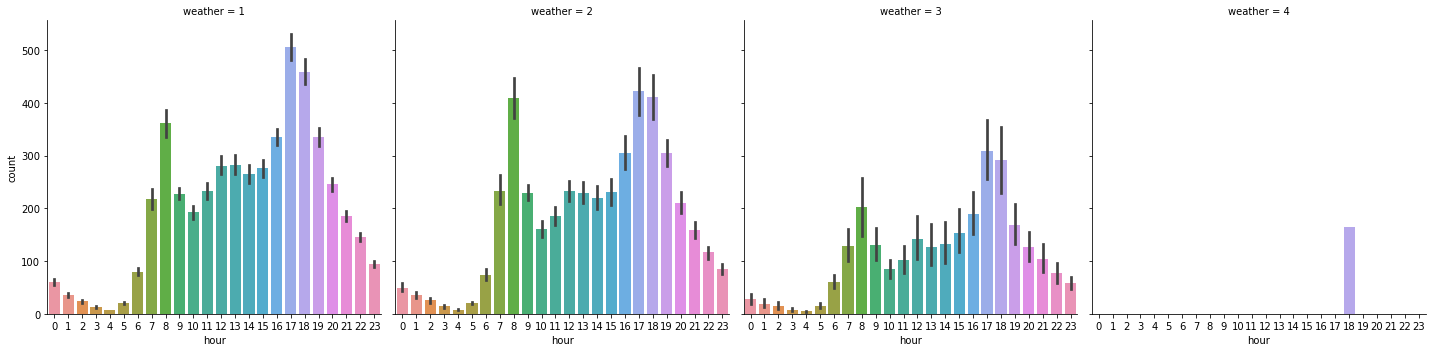

In [13]:
#peak timings according to weather condition
sns.catplot(x="hour",y="count",col="weather",data=train,kind='bar')

Weather conditions have no influence on peak timings as those are generally the arrival and departure timings of offices. Only the amount of rentals changes as per the weather but the peak timings remains the same.

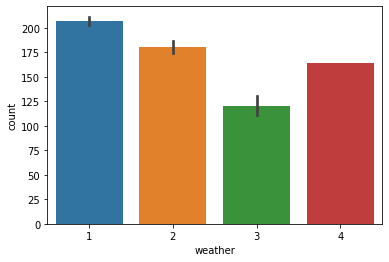

In [14]:
#Counts due to weather conditions
sns.barplot(x="weather", y="count",data=train)

from the above graph we conclude that most of the rentals are in clear weather

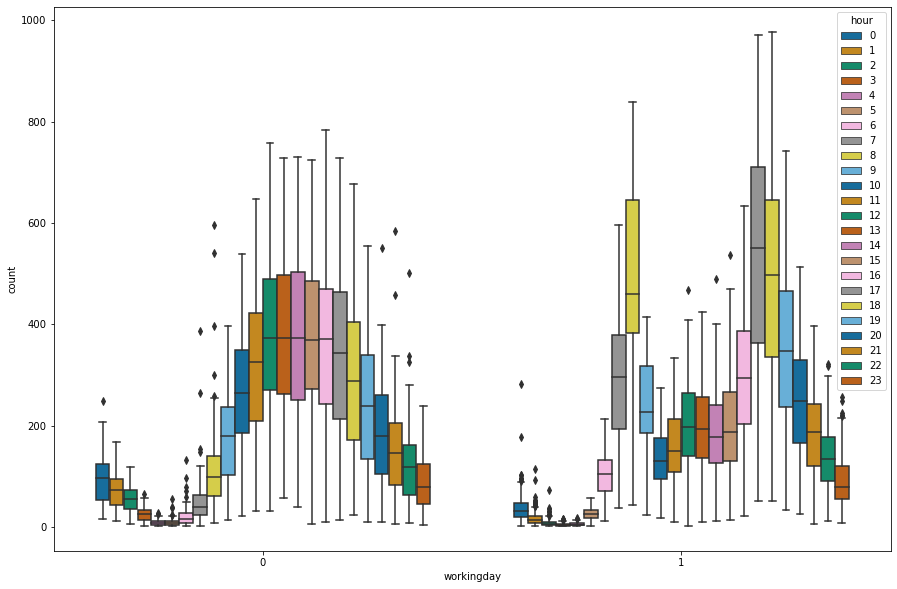

In [15]:
#influence of working day on counts as per timings 
plt.figure(figsize=(15,10))
sns.boxplot(y='count', x="workingday", data=train, palette="colorblind",hue='hour')

this tells us that only on working days we have peaks around 8 a.m and 5-6 p.m on other days that is weekends and holidays peaks are in evening as people go out to roam

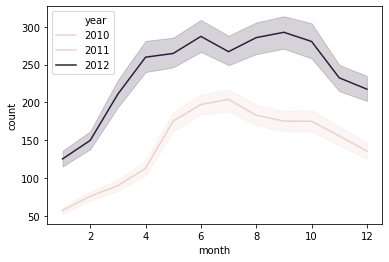

In [16]:
#number of rentals over the years
sns.lineplot(x="month", y="count",hue="year", markers=True, dashes=False, data=train)  

over the years the number of rentals have increased

In [17]:
#one hot encoding season and weather column
columns=["season","weather"]
for col in columns:
    for i in train.groupby(col).count().index:
        c=col+str(i)
        train[c]=0
        for j in train[col]:
            if (j==i):
                train[c].replace({0:1}, inplace=True)
            else:
                train[c]=0
train=train.drop(columns=["season","weather"],axis=1)
train.head(5)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,weekday,weekend,season1,season2,season3,season4,weather1,weather2,weather3,weather4
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,5,1,0,0,0,1,1,0,0,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,5,1,0,0,0,1,1,0,0,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,5,1,0,0,0,1,1,0,0,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,5,1,0,0,0,1,1,0,0,0
6,2011-01-01 06:00:00,0,0,9.02,13.635,80,0.0,2,0,2,...,5,1,0,0,0,1,1,0,0,0


In [18]:
columns=["season","weather"]
for col in columns:
    for i in test.groupby(col).count().index:
        c=col+str(i)
        test[c]=0
        for j in test[col]:
            if (j==i):
                train[c].replace({0:1}, inplace=True)
            else:
                test[c]=0
test=test.drop(columns=["season","weather"],axis=1)
test.head(5)

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weekday,hour,day,...,year,weekend,season1,season2,season3,season4,weather1,weather2,weather3,weather4
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,3,0,20,...,2011,0,0,0,0,0,0,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,3,1,20,...,2011,0,0,0,0,0,0,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,3,2,20,...,2011,0,0,0,0,0,0,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,3,3,20,...,2011,0,0,0,0,0,0,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,3,4,20,...,2011,0,0,0,0,0,0,0,0,0


In [19]:
#mean encoding the hour column as seems to be an important factor 
columns=["hour"]
for x in columns: 
    mean_encode=train.groupby(x)["count"].mean()
    train.loc[:,x]=train[x].map(mean_encode)
    test.loc[:,x]=test[x].map(mean_encode)
    test[x]=test[x] / test[x].max()
    train[x]=train[x] / train[x].max()

In [20]:
train=train.drop(columns=["registered","casual","atemp","datetime","weekday"],axis=1)
d=test["datetime"]
test=test.drop(columns=["atemp","datetime","weekday"],axis=1)

In [21]:
train.shape

(10781, 19)

Here we will predict our data using stacking regressor.Stacking is an ensemble machine learning algorithm that combines various classification or regression models to compute the final prediction. We stack all our base estimators i.e, decision tree,random forest,gradient boosting and adaboosting models. These base estimators are then combined using our final estimator i.e, xgboost.
So se first look over different regressor models accuacy using  to show why are we using stacking regressor to test the model.

In [22]:
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=100)
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(criterion = 'mse')
parameters = {"max_depth": [5,10,15,20],
             "min_samples_split": [2,4,6,8],
             "min_samples_leaf": [2,4,6,8,10]}
m1= GridSearchCV(reg, parameters, cv=5, verbose=2,n_jobs=-1)
m1.fit(train.drop(["count"], axis=1), train["count"])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_s

In [23]:
decision_tree = model_selection.cross_val_score(m1,train.drop(["count"], axis=1), train["count"], cv=kfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    4.0s finished


In [24]:
print("Accuracy using decision tree: %.2f%%" % (decision_tree.mean()*100.0))

Accuracy using decision tree: 66.74%


In [25]:
rf=RandomForestRegressor(criterion = 'mse')
parameters = {"max_depth": [5,10,15,20],
             "min_samples_split": [2,4,6,8],
             "min_samples_leaf": [2,4,6,8,10]}
m2=GridSearchCV(rf, parameters, cv=5, verbose=2,n_jobs=-1)
m2.fit(train.drop(["count"], axis=1), train["count"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [26]:
random_forest = model_selection.cross_val_score(m2,train.drop(["count"], axis=1), train["count"], cv=kfold)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


In [27]:
print("Accuracy using random forest: %.2f%%" % (random_forest.mean()*100.0))

Accuracy using random forest: 78.87%


In [28]:
gb=GradientBoostingRegressor(criterion = 'mse')
parameters = {"max_depth": [5,10,15,20],
             "min_samples_split": [2,4,6,8],
             "min_samples_leaf": [2,4,6,8,10]}
m3=GridSearchCV(rf, parameters, cv=5, verbose=2,n_jobs=-1)
m3.fit(train.drop(["count"], axis=1), train["count"])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [29]:
gradient_boost= model_selection.cross_val_score(m3,train.drop(["count"], axis=1), train["count"], cv=kfold)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


In [30]:
print("Accuracy using gradient boost: %.2f%%" % (gradient_boost.mean()*100.0))

Accuracy using gradient boost: 79.05%


In [31]:
xg = xgb.XGBRegressor(criterion = 'mse')
parameters = {"max_depth": [5,10,15,20],
             "learning rate": [0.1,0.01,0.001,0.9],
             "alpha":[0,1,10],}
m4 = GridSearchCV(xg, parameters, cv=5, verbose=2)
m4.fit(train.drop(["count"], axis=1), train["count"])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.1s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, criterion='mse',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constrain...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [32]:
extreme_gradient_boost = model_selection.cross_val_score(m4,train.drop(["count"], axis=1), train["count"], cv=kfold)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.9min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.1min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.0min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.1min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.9min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.1s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.1min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.9min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.9min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.9min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.4s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.0min finished


In [33]:
print("Accuracy using extreme gradient boost: %.2f%%" % (extreme_gradient_boost.mean()*100.0))

Accuracy using extreme gradient boost: 80.86%


In [34]:
st= StackingRegressor(regressors=(m1,m2,m3), 
                               meta_regressor=m4,
                               use_features_in_secondary=True)
st.fit(train.drop(["count"], axis=1), train["count"])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.7min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.7min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.8s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.7min finished


StackingRegressor(meta_regressor=GridSearchCV(cv=5, error_score=nan,
                                              estimator=XGBRegressor(base_score=None,
                                                                     booster=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     criterion='mse',
                                                                     gamma=None,
                                                                     gpu_id=None,
                                                                     importance_type='gain',
                                                                     interaction_constraints=None,
                                            

In [35]:
stacked = model_selection.cross_val_score(st,train.drop(["count"], axis=1), train["count"], cv=kfold)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.0min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.9s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.0min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.8s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.0min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   1.0s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.8s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.9min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.1min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.9s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.8s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.8s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.8min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   1.2s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.8s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.5s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.3min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.1min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.4s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.0min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.5min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.6s
[CV] alpha=0, learning rate=0.1, max_depth=5 .........................
[CV] .......... alpha=0, learning rate=0.1, max_depth=5, total=   0.7s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] ......... alpha=0, learning rate=0.1, max_depth=10, total=   1.3s
[CV] alpha=0, learning rate=0.1, max_depth=10 ........................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.0min finished


In [36]:
print("Accuracy using stacking: %.2f%%" % (stacked.mean()*100.0))

Accuracy using stacking: 78.51%


In [37]:
ans=st.predict(test)
ans[ans<0] = min(train["count"])

In [38]:
ans=np.round(ans)
ans

array([ 14.,   7.,   6., ..., 181., 117.,  72.], dtype=float32)

In [39]:
result = pd.DataFrame(data = {"datetime":d,"count":ans})
result.to_csv("stacked",index=False)